# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

In [31]:
library = library_designer.design(
    molecules = [deck[414]],
    num_analogs = 300_000,
    fraction_random = 0.0
)

In [43]:
reactions = library_designer.find_compatible_reactions(deck[414])

In [56]:
# library_designer.enumerate_analogs??

In [151]:
res = library_designer.design(
    molecules = [library[10_000]],
    num_analogs = 10,
    fraction_random = 0.0
)

In [161]:
library.unique().annotations

,smiles
0,Cc1ccc(C(=O)N(C(=O)NCc2ccccc2)c2ccc(O)c(C(=O)O...
1,Cc1ccc(C(=O)N(C)c2cc(F)ccc2C)s1
2,COc1ccccc1NC(=O)[C@@H]1CC[C@H]1C
3,COCC1(CCNC(=O)c2ccc(C)s2)CCCC1
4,COc1ccccc1NC(=O)Cc1ccc(CNC(=O)OCC2c3ccccc3-c3c...
...,...
174981,COc1ccccc1NC(=O)c1oc2ccccc2c1CO
174982,COc1ccccc1NC(=O)COc1ccc(/C=N/NC(N)=O)cc1OC
174983,Cc1ccc(C(=O)N2CCC(F)(CBr)CC2)s1
174984,COC(=O)c1ccc(OCCNC(=O)c2ccc(C)s2)cc1


In [61]:
import numpy as np
from sklearn.metrics import pairwise_distances

def jaccard_similarity_sklearn(reactions):
    """
    Compute the Jaccard similarity between each pair of reactions using scikit-learn.

    Parameters
    ----------
    reactions : list of numpy arrays
        A list where each numpy array represents a reaction with its compounds as integers.

    Returns
    -------
    np.ndarray
        A 2D numpy array containing the Jaccard similarities between each pair of reactions.

    Example
    -------
    >>> reactions = [np.array([1, 2, 3]), np.array([2, 3, 4]), np.array([1, 2])]
    >>> jaccard_similarity_sklearn(reactions)
    """
    # Identify all unique compounds
    unique_compounds = np.unique(np.concatenate(reactions))

    # Create a boolean matrix for the reactions
    reaction_matrix = np.array([np.in1d(unique_compounds, reaction)
                                for reaction in reactions])

    # Compute Jaccard distances and convert them to similarities
    jaccard_distances = pairwise_distances(reaction_matrix, metric='jaccard')
    jaccard_similarity = 1 - jaccard_distances

    return jaccard_similarity

reaction_indices = []
for reaction in building_blocks:
    reaction_index = building_blocks[reaction]['index']
    reaction_indices.append(reaction_index)
    
reaction_distances = jaccard_similarity_sklearn(reaction_indices)

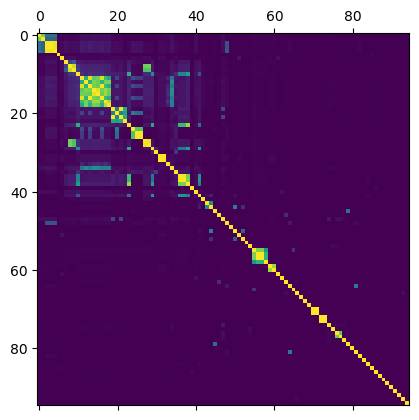

In [68]:
import matplotlib.pyplot as plt
plt.matshow(reaction_distances)

In [196]:
def find_identical_reactions(jaccard_matrix, threshold=1.0):
    """
    Find pairs of reactions that are identical (Jaccard similarity equals 1) in the given Jaccard similarity matrix.

    Parameters
    ----------
    jaccard_matrix : np.ndarray
        A 2D numpy array containing the Jaccard similarities between each pair of reactions.

    Returns
    -------
    list of tuples
        A list of tuples, where each tuple contains the indices of the reactions that are identical.

    Example
    -------
    >>> jaccard_matrix = np.array([[1.0, 0.5, 1.0], [0.5, 1.0, 0.5], [1.0, 0.5, 1.0]])
    >>> find_identical_reactions(jaccard_matrix)
    [(0, 2), (2, 0)]
    """
    identical_pairs = []
    n = len(jaccard_matrix)

    for i in range(n):
        for j in range(i+1, n):  # Consider only upper triangular part to avoid duplicates
            if jaccard_matrix[i, j] >= threshold:
                identical_pairs.append((i, j))

    return identical_pairs

In [194]:
identical_reactions = find_identical_reactions(reaction_distances)

In [219]:
idx = 13

reaction_names = list(building_blocks.keys())

idx_1, idx_2 = identical_reactions[idx][0], identical_reactions[idx][1]
display(reaction_names[idx_1])
display(reaction_names[idx_2])

IndexError: list index out of range